In [1]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
from scipy.optimize import curve_fit
from matplotlib import cm

In [2]:
def moving_average(a, n = 3, start_smooth = 100):
    a_start = a[:start_smooth]
    a_end = a[start_smooth:]
    ret = np.cumsum(a_end, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.concatenate((a_start, ret[n - 1:] / n))

In [3]:
def power_law_fit(x, a):
    ''' Use this to fit f^-2 (intermediate f) '''
    return a * x ** (-2)

In [27]:
# Plotting settings:
plt.rc('text', usetex=True)
plt.rc('font', size = 170, weight = 'bold')
plt.rcParams['xtick.major.width'] = 8
plt.rcParams['xtick.major.size'] = 30
plt.rcParams['ytick.major.width'] = 8
plt.rcParams['ytick.major.size'] = 30

## SFS

In [5]:
# import data

L = 500
rho = 20000
N = L * rho
s = 0.05
m = 0.25
tfinal = 1000000
Un = 1
r = 0
n_forward = 100
n = 100000
n_wellmixed = 10000
nSFS = 1000
nsim_wellmixed = 1000
tfix = 0

f = np.arange(1, n + 1) / n
f_wellmixed = np.arange(1, n_wellmixed + 1) / n_wellmixed
navg = 30
start_smooth = 100
f_short = moving_average(f, navg, start_smooth)

# Find v from lines

freq_file = open(
   'forward_simulation_data/L={}_N={}_s={:.6f}_m={:.6f}_tfinal={}_0.txt'.format(L, rho, s, m, tfinal))
lines = np.loadtxt(freq_file, dtype=np.int64)
tf_real = len(lines)
v_list = []
for t in np.arange(int(tf_real / 4), int(tf_real * 3 / 4)):
    line1 = lines[t]
    line2 = lines[t + 1]
    psum1 = sum(line1) / rho
    psum2 = sum(line2) / rho
    v_list.append(psum2 - psum1)

v = np.average(v_list)


SFS = np.loadtxt(
    'backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS))


SFS_well_mixed = np.loadtxt('backward_simulation_data/expected_SFS_well_mixed_N={}_Tfix={}_s={:.2f}_r={:.2e}_nsample={}_nsim={}.txt'.format(
        N, tfix, s, r, n_wellmixed, nsim_wellmixed))
SFS_well_mixed2 = np.loadtxt('backward_simulation_data/expected_SFS_well_mixed_N={}_Tfix={}_s={:.2f}_r={:.2e}_nsample={}_nsim={}.txt'.format(
        N, tfix, s, r, n, 20))

f_wellmixed_combined = np.append(f[:78], f_wellmixed[8:])
SFS_wellmixed_combined = np.append(SFS_well_mixed2[:78], SFS_well_mixed[8:])

In [6]:
# smooth curves

smooth_SFS_wellmixed_combined = moving_average(SFS_wellmixed_combined, navg, start_smooth)
smooth_SFS = moving_average(SFS, navg, start_smooth)

## Overall allele frequency spectra

/Users/dbweiss/Library/Python/3.10/lib/python/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child2), but could not find a label for it.
  warnings.warn(
/Users/dbweiss/Library/Python/3.10/lib/python/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child4), but could not find a label for it.
  warnings.warn(


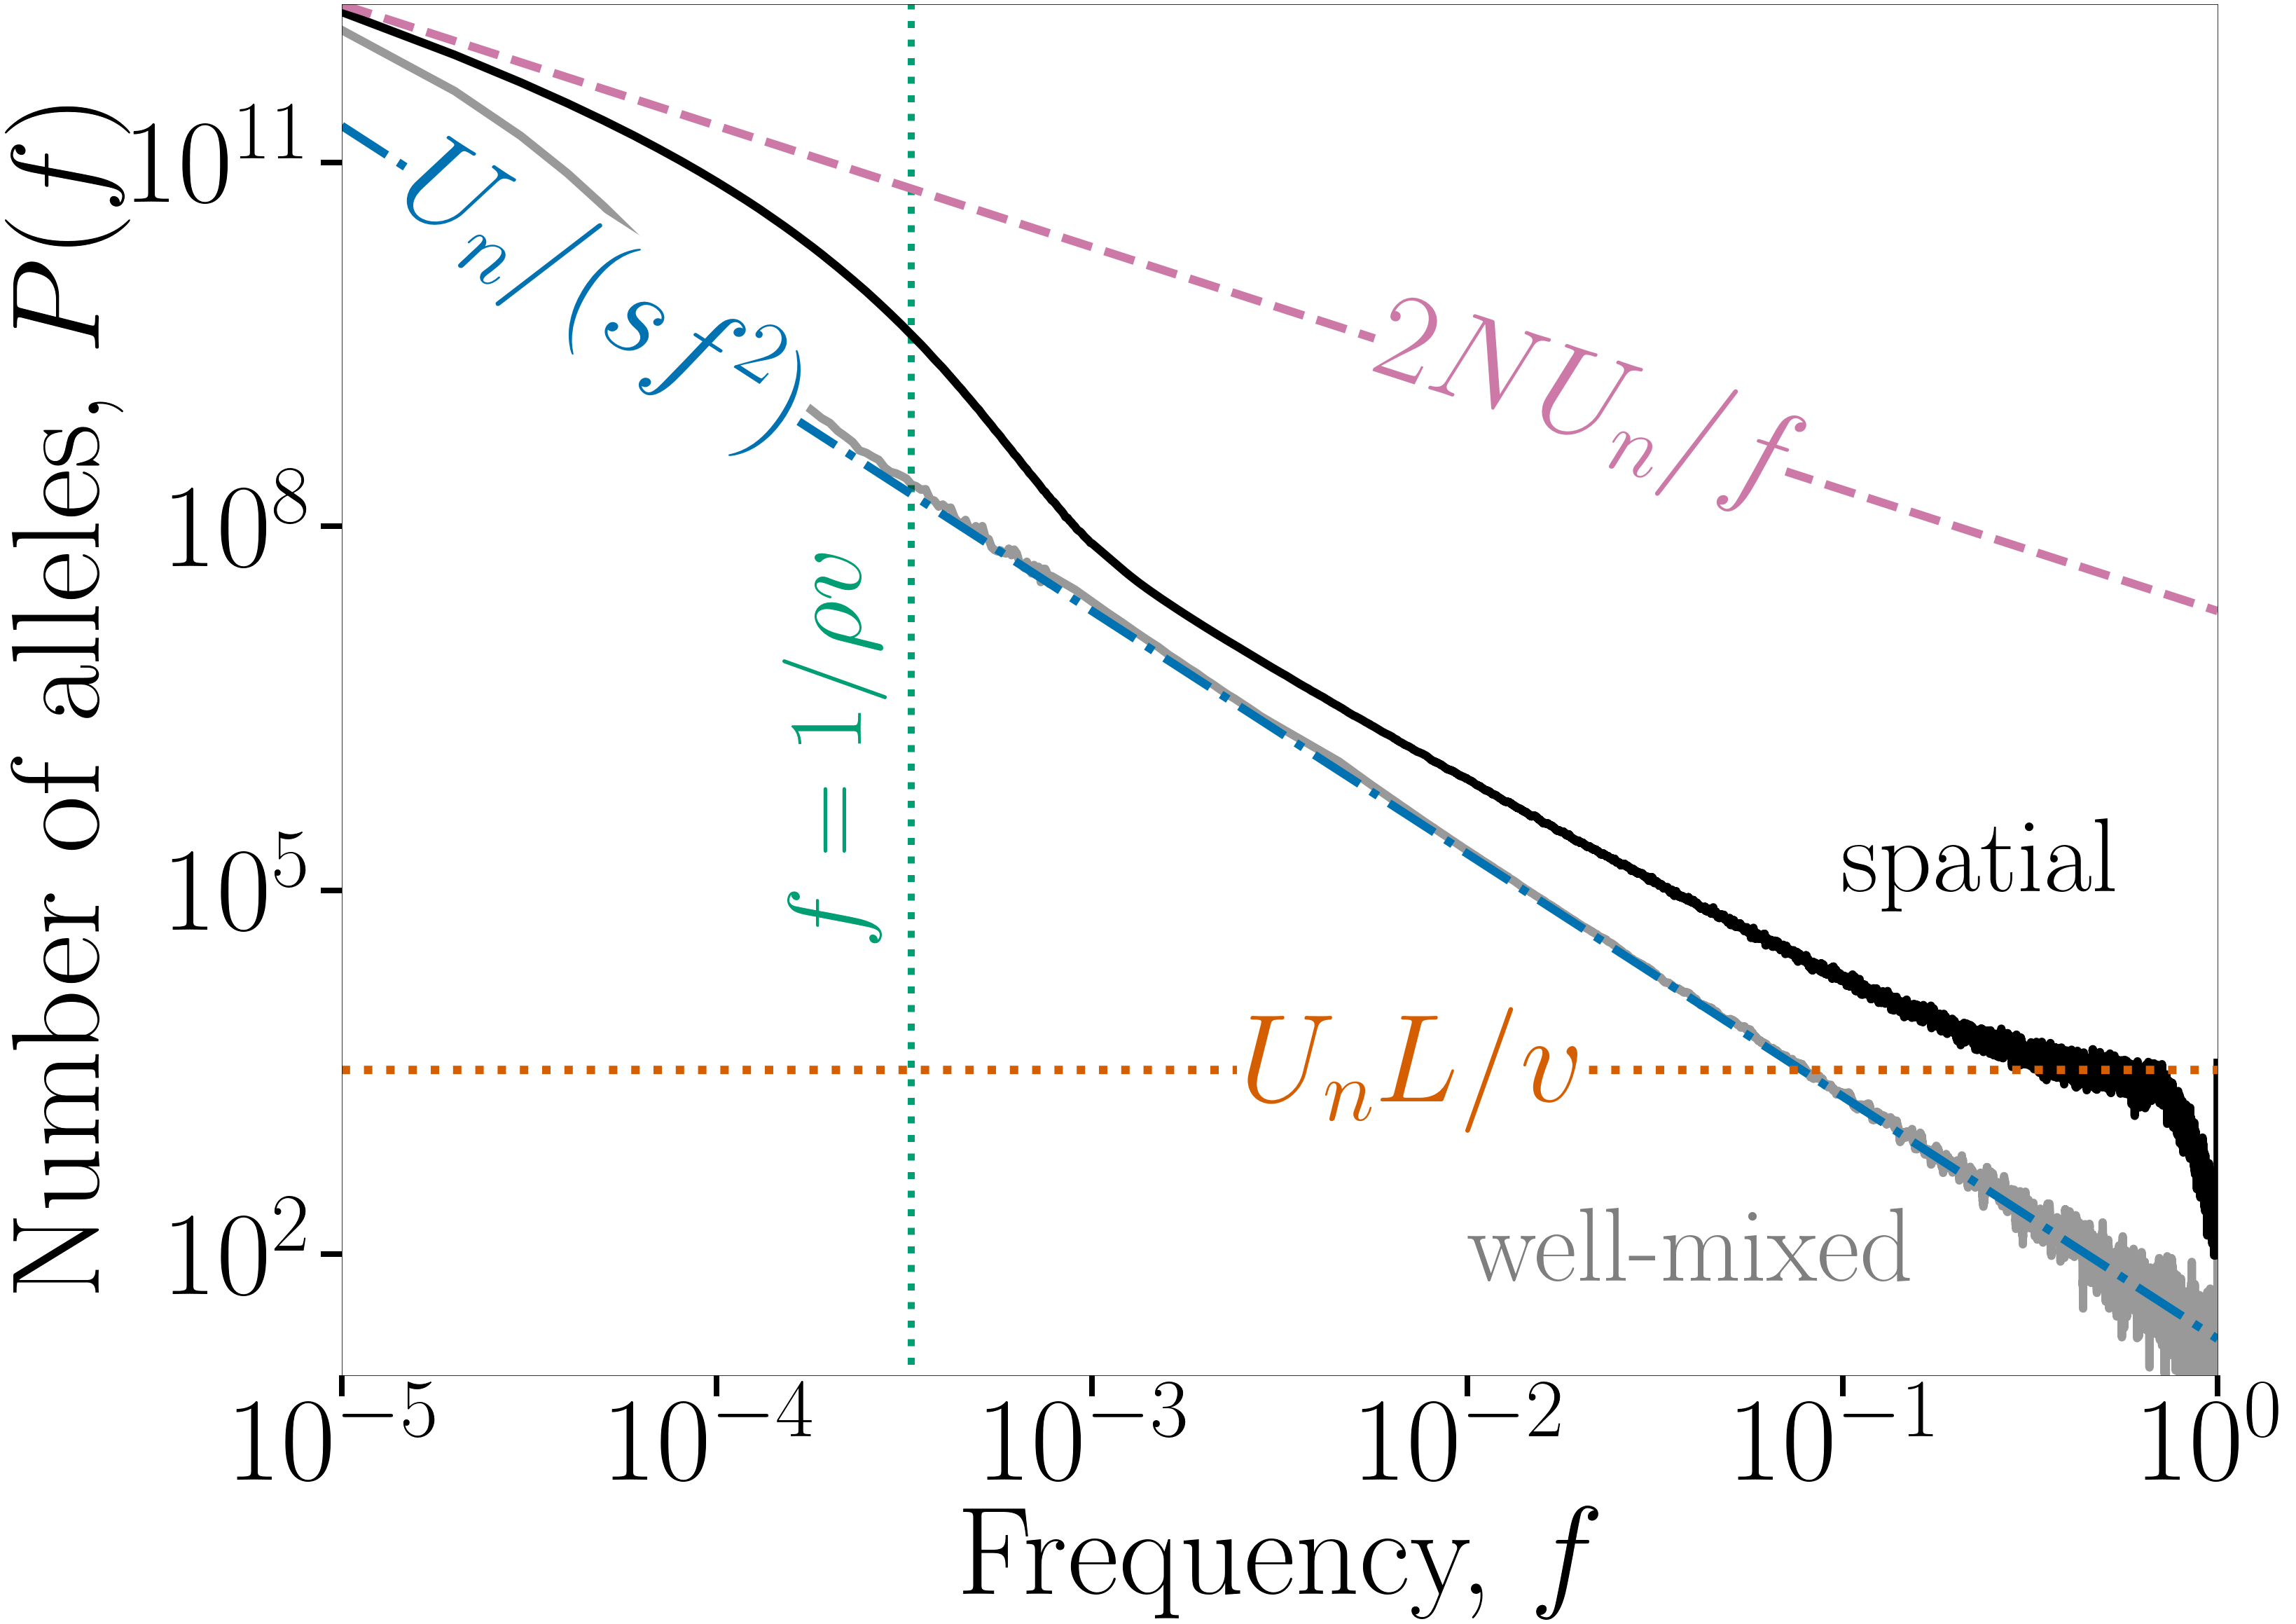

In [9]:
# plot the figure on a loglog scale

fig, ax = plt.subplots(figsize = (48,36))
ax.set_xlabel(r'Frequency, $f$', fontsize = 180)
ax.set_ylabel(r'Number of alleles, $P(f)$', fontsize = 180)

ax.vlines(1 / (rho * v), 10 ** (-2), 10 ** 15, linestyle = 'dotted', linewidth = 10, color = '#009e73')
ax.text(1.5e-4, 6e4, r'$f = 1 / \rho v$', color = '#009e73', fontsize = 150, rotation = 90, 
         backgroundcolor = 'w')

#plt.text(0.002, 3 * 10 ** 5, r'$U_n \ln( N s f) / (s f^2)$', color = '#0072b2', fontsize = 150, rotation = -25)
#        
ax.loglog(moving_average(f_wellmixed_combined, navg, start_smooth), smooth_SFS_wellmixed_combined, 
             linewidth = 12, color = 'k', alpha = 0.4)
ax.text(10 ** (-2), 60, 'well-mixed', color = 'k', alpha = 0.5, fontsize = 150, backgroundcolor = 'w')

ax.loglog(f_short, smooth_SFS, linewidth = 12, color = 'k')
ax.text(10 ** (-1), 10 ** 5, 'spatial', color = 'k', fontsize = 150, backgroundcolor = 'w')

neutral, = ax.loglog(f_short, 2 * Un * rho * L * np.ones(len(f_short)) / f_short,
           label = r'$2 N U_n / f$', linestyle = '--', linewidth = 12, color = '#cc79a7')


bsc, = ax.loglog(f_short, Un / s / f_short ** 2, linestyle = '-.', linewidth = 12, color = '#0072b2', 
           label = r'$U_n / (sf^2)$')


flat, = ax.semilogy(f_short, np.ones(len(f_short)) * L / v, linewidth = 12, linestyle = 'dotted',
              label = r'$U_n L / v$', color = '#d55e00')

ax.set_ylim((10, 2 * 10 ** 12))
ax.set_xlim((1e-5, 1))

plt.xticks(np.logspace(-5,0,6))
plt.yticks(np.logspace(2,11,4))

xvals = [0.02, 0.00005, 0.007]
labelLines(ax.get_lines(), xvals = xvals, fontsize = 180, backgroundcolor = 'w');

In [8]:
# save the figure

fig.savefig('Figure2_loglog.pdf', format = 'pdf', bbox_inches = 'tight')

 ## Allele frequency spectra just in the surfing range

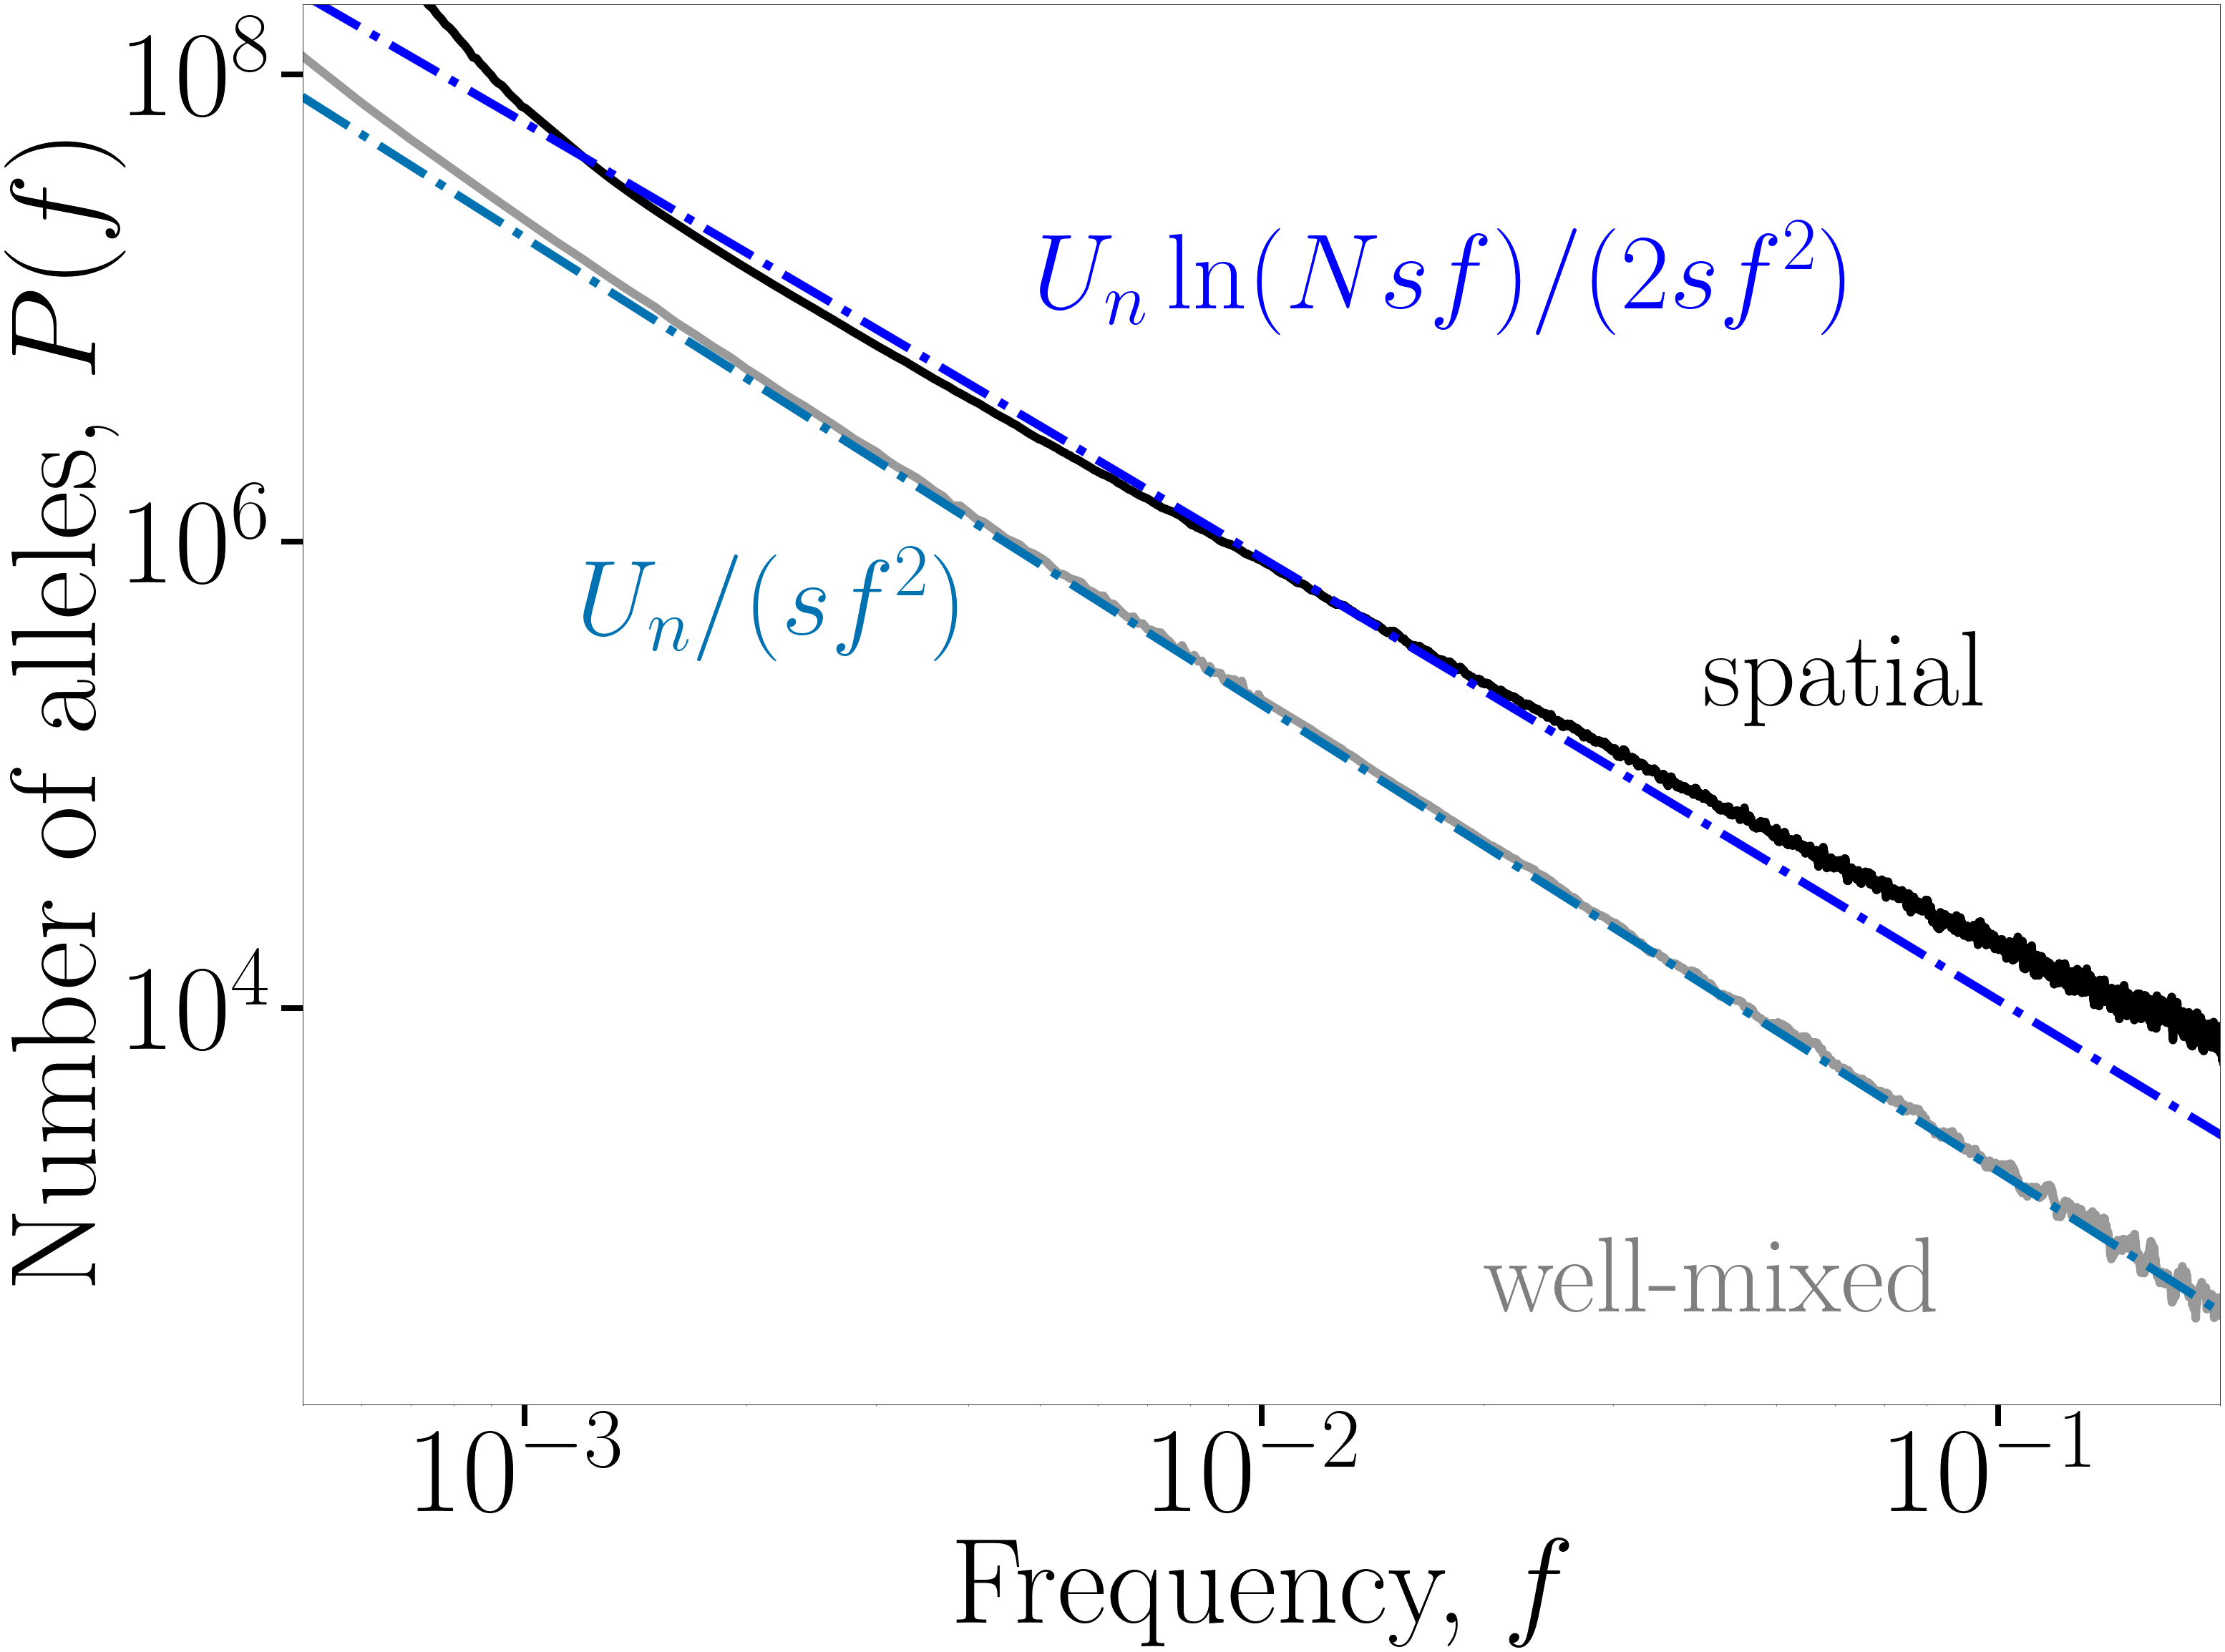

In [9]:
# plt.rc('font', family='serif', size = 150, weight = 'bold')
fig, ax = plt.subplots(figsize = (48, 36))
ax.set_xlabel(r'Frequency, $f$')
ax.set_ylabel(r'Number of alleles, $P(f)$')

ax.loglog(moving_average(f_wellmixed, navg, start_smooth), moving_average(SFS_well_mixed, navg, start_smooth), 
             linewidth = 12, color = 'k', alpha = 0.4)

ax.loglog(f_short, moving_average(SFS, navg, start_smooth), linewidth = 12, color = 'k')

bsc, = ax.loglog(f_short, Un / s / f_short ** 2, linestyle = '-.', linewidth = 12, color = '#0072b2', 
           label = r'$\boldmath{U_n / (sf^2)}$')
bsc2, = ax.loglog(f_short, Un * np.log(N * s * f_short) / s / f_short ** 2 / 2, 
           linestyle = '-.', linewidth = 12, color = 'b', label = r'$\boldmath{U_n \ln(Nsf) / (2 sf^2)}$')


ax.text(4 * 10 ** (-2), 2 * 10 ** 5, 'spatial', color = 'k', fontsize = 150, backgroundcolor = 'w')
ax.text(2 * 10 ** (-2), 5 * 10 ** 2, 'well-mixed', color = 'k', alpha = 0.5, fontsize = 150, backgroundcolor = 'w')
ax.text(5 * 10 ** (-3), 10 ** 7, r'$\boldmath{U_n \ln(Nsf) / (2 sf^2)}$',  
         color = 'b', fontsize = 150, backgroundcolor = 'w')
ax.text(1.2 * 10 ** (-3), 4 * 10 ** 5, r'$\boldmath{U_n / (sf^2)}$', 
        color = '#0072b2', fontsize = 150, backgroundcolor = 'w')

ax.set_xlim((5 * 10 ** -4, 2 * 10 ** -1))
ax.set_ylim((200, 2 * 10 ** 8));

In [10]:
# save the figure
fig.savefig('Figure3a.pdf', format = 'pdf', bbox_inches = 'tight')

# Showing the collapse of different parameter combinations for surfing SFS

In [21]:
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size = 60, weight = 'bold')
Un = 1
r = 0
n_forward = 100
tfix = 0

n = 100000
nSFS = 1000

blue_cmap = cm.get_cmap('Blues')
red_cmap = cm.get_cmap('Reds')
grey_cmap = cm.get_cmap('Greys')

slist = np.arange(0.02, 0.07, 0.01)
mlist = np.arange(0.2, 0.55, 0.05)
Lrholist = [[500, 2000], [1000, 10000], [1000, 1000], [2000, 5000]]
tfinallist = [10000, 100000, 100000, 100000]

xpositions = [10**(-3), 10**(-3), 10**(-3), 6 * 10 ** (-5), 6 * 10 ** (-5)]
ypositions = [10 ** 5, 10 ** 4, 10 ** 3, 10 ** 4, 10 ** 3]

fitlist = []

f = np.arange(1, n + 1) / n
navg = 30
start_smooth = 100
f_short = moving_average(f, navg, start_smooth)

fit_range_ind = np.arange(200,1000)

In [38]:
# import data for varying s

m = 0.25
L = 500
rho = 20000
N = rho * L
tfinal = 1000000

filenames = ['backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS) for s in slist]
svar_smooth_SFS = [moving_average(np.loadtxt(filenames[sind]) * s / np.log(N * s * f), navg, start_smooth) for sind, s in enumerate(slist)]

svar_fstart_ind = [int(10 / (rho * np.sqrt(m * s)) * n) for s in slist]

In [39]:
# import data for varying m

s = 0.05
L = 500
rho = 20000
tfinal = 1000000

filenames = ['backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS) for m in mlist]
mvar_smooth_SFS = [moving_average(np.loadtxt(filenames[mind]) * s / np.log(N * s * f), navg, start_smooth) for mind, m in enumerate(mlist)]

mvar_fstart_ind = [int(10 / (rho * np.sqrt(m * s)) * n) for m in mlist]

In [ ]:
# import data for varying L and rho

s = 0.05
m = 0.25

filenames = ['backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(Lrho[0], 
                 Lrho[1], s, m, r, tfinallist[ind], n, tfix, nSFS) for ind, Lrho in enumerate(Lrholist)]

for Lrhoind in range(len(Lrholist)):
    L, rho = Lrholist[Lrhoind]
    N = L * rho
    tfinal = tfinallist[Lrhoind]
    fstart_ind = int(10 / (rho * np.sqrt(m * s)) * n)

    SFS = np.loadtxt(
        'backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS))

    y_smooth = moving_average(SFS * s / np.log(N * s * f), navg, start_smooth)

    Lrho_plot = ax.scatter(f_short[fstart_ind::15], y_smooth[fstart_ind::15], s = 250, marker = '*', color = grey_cmap(100 - Lrhoind * 10))
    # Lrho_plot = ax.plot(f_short[fstart_ind::15], y_smooth[fstart_ind::15], color = grey_cmap(100 - Lrhoind * 10))

    vary_Lrho_list.append(Lrho_plot)
vary_Lrho_tuple = tuple(vary_Lrho_list)

In [ ]:
fig, ax = plt.subplots(figsize = (48, 36));

vary_s_list = []

for sind, s in enumerate(slist):
    fstart_ind = int(10 / (rho * np.sqrt(m * s)) * n)
    SFS = np.loadtxt(
        'backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS))

    vary_s_y_smooth = moving_average(SFS * s / np.log(N * s * f), navg, start_smooth)

    s_plot = ax.scatter(f_short[fstart_ind::30], y_smooth[fstart_ind::30], s = 250, marker = 'v', color = blue_cmap(100 - sind * 10));
    # s_plot = ax.plot(f_short[fstart_ind::30], y_smooth[fstart_ind::30], color = blue_cmap(100 - sind * 10))

    vary_s_list.append(s_plot)
    
vary_s_tuple = tuple(vary_s_list)

In [23]:
s = 0.05
L = 500
rho = 20000
tfinal = 1000000


vary_m_list = []
for mind in range(len(mlist)):
    m = mlist[mind]
    N = rho * L

    fstart_ind = int(10 / (rho * np.sqrt(m * s)) * n)    
    SFS = np.loadtxt(
        'backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS))

    y_smooth = moving_average(SFS * s / np.log(N * s * f), navg, start_smooth)

    m_plot = ax.scatter(f_short[fstart_ind::30], y_smooth[fstart_ind::30], s = 250, marker = 'o', color = red_cmap(100 - mind * 10))
    # m_plot = ax.plot(f_short[fstart_ind::30], y_smooth[fstart_ind::30], color = red_cmap(100 - mind * 10))

    vary_m_list.append(m_plot)
vary_m_tuple = tuple(vary_m_list)

In [24]:
s = 0.05
m = 0.25

vary_Lrho_list = []    
for Lrhoind in range(len(Lrholist)):
    L, rho = Lrholist[Lrhoind]
    N = L * rho
    tfinal = tfinallist[Lrhoind]
    fstart_ind = int(10 / (rho * np.sqrt(m * s)) * n)

    SFS = np.loadtxt(
        'backward_simulation_data/expected_SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS))

    y_smooth = moving_average(SFS * s / np.log(N * s * f), navg, start_smooth)

    Lrho_plot = ax.scatter(f_short[fstart_ind::15], y_smooth[fstart_ind::15], s = 250, marker = '*', color = grey_cmap(100 - Lrhoind * 10))
    # Lrho_plot = ax.plot(f_short[fstart_ind::15], y_smooth[fstart_ind::15], color = grey_cmap(100 - Lrhoind * 10))

    vary_Lrho_list.append(Lrho_plot)
vary_Lrho_tuple = tuple(vary_Lrho_list)

/var/folders/n6/lxg0vmdj2cq670yzgtww8smr0000gn/T/ipykernel_15264/1942131799.py:15: RuntimeWarning: divide by zero encountered in true_divide
  y_smooth = moving_average(SFS * s / np.log(N * s * f), navg, start_smooth)


In [28]:
# plot parameter collapse figure:

ax.loglog()
ax.set_xlim((3 * 10 ** -3, 10 ** -1))
ax.set_ylim((5 * 10, 5 * 10 ** 4))
ax.set_xlabel('Frequency, ' + r'$\boldmath{f}$')
ax.set_ylabel('Scaled number of alleles\n'+r'$\boldmath{P(f) s / \ln(Nsf)}$')
ax.legend([vary_s_tuple, vary_m_tuple, vary_Lrho_tuple], [r'vary $s$, '
          + r'$m = 0.25, L = 500, \rho = 2\times 10^4$', 
          r'vary $m$, '
          + r' $s = 0.05, L = 500, \rho = 2\times 10^4$', 
          r'vary $\rho$ and $L$, ' 
          + r'$s = 0.05, m = 0.25$'], fontsize = 100, handler_map={tuple: HandlerTuple(ndivide=None)})

In [27]:
# save figure:
fig.savefig('Figure3b_new.pdf', format = 'pdf', bbox_inches = 'tight')

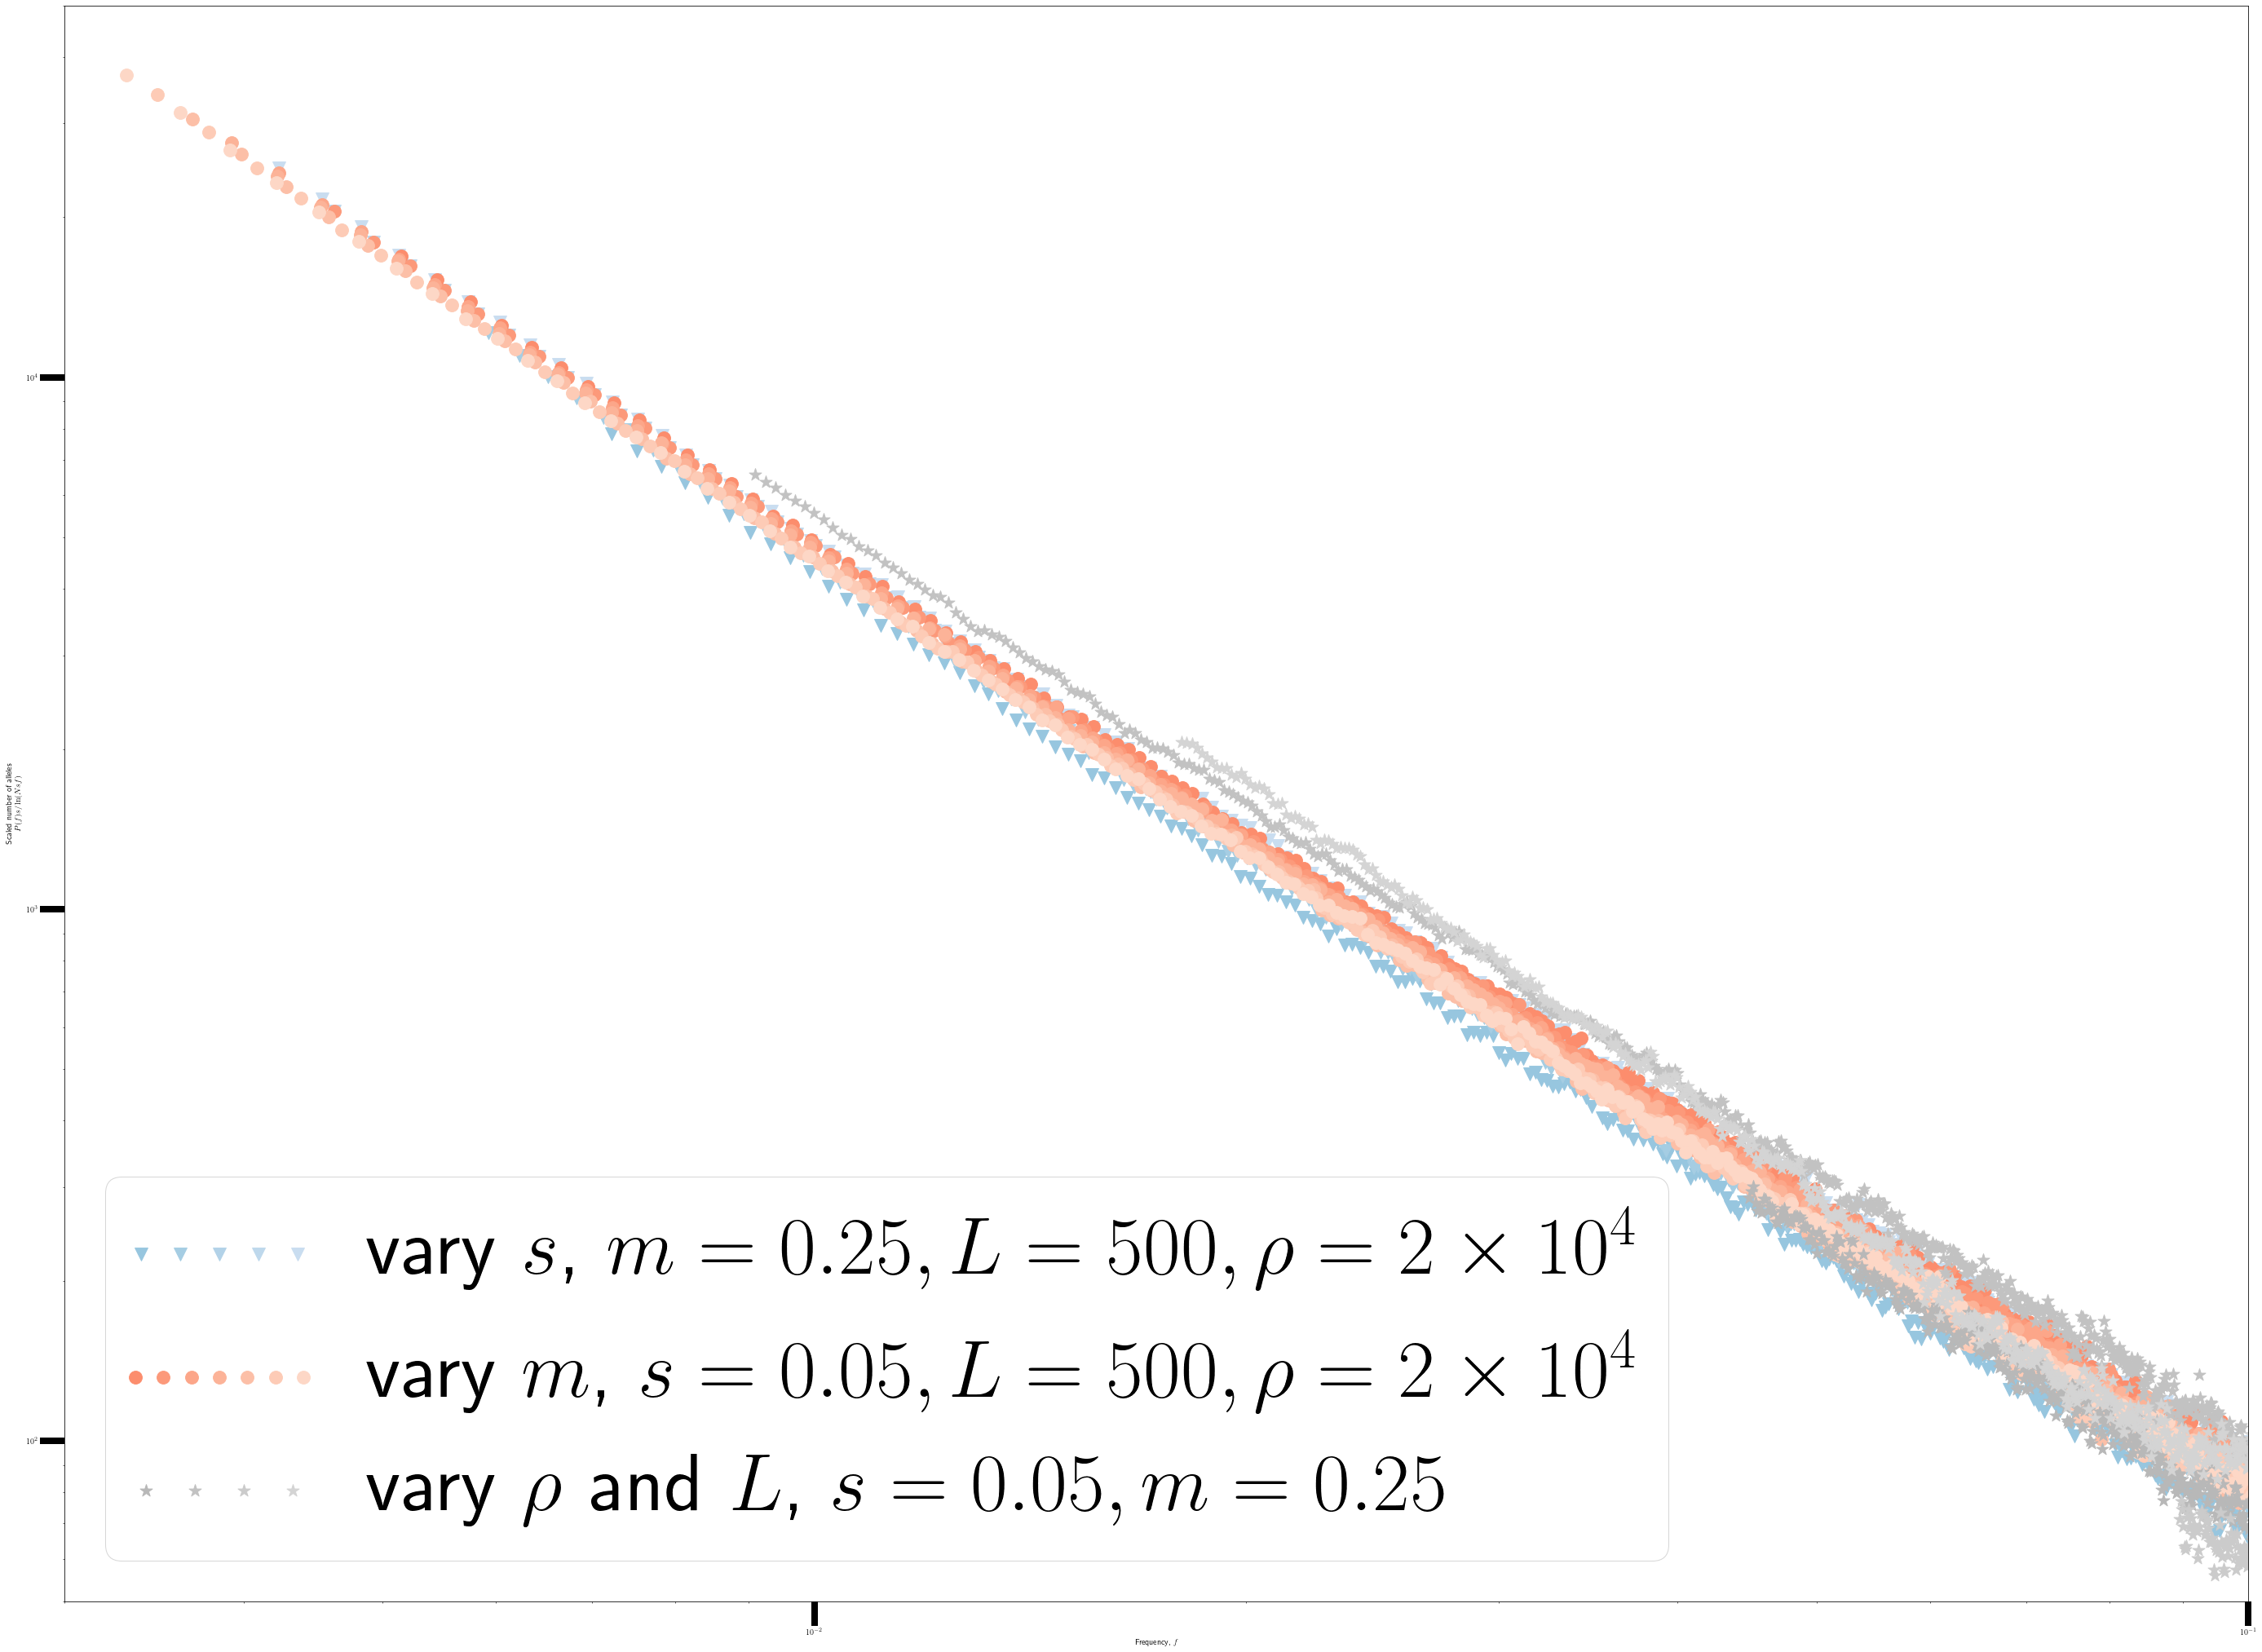

In [29]:
fig

### Uniform tail

(1e-06, 0.99)

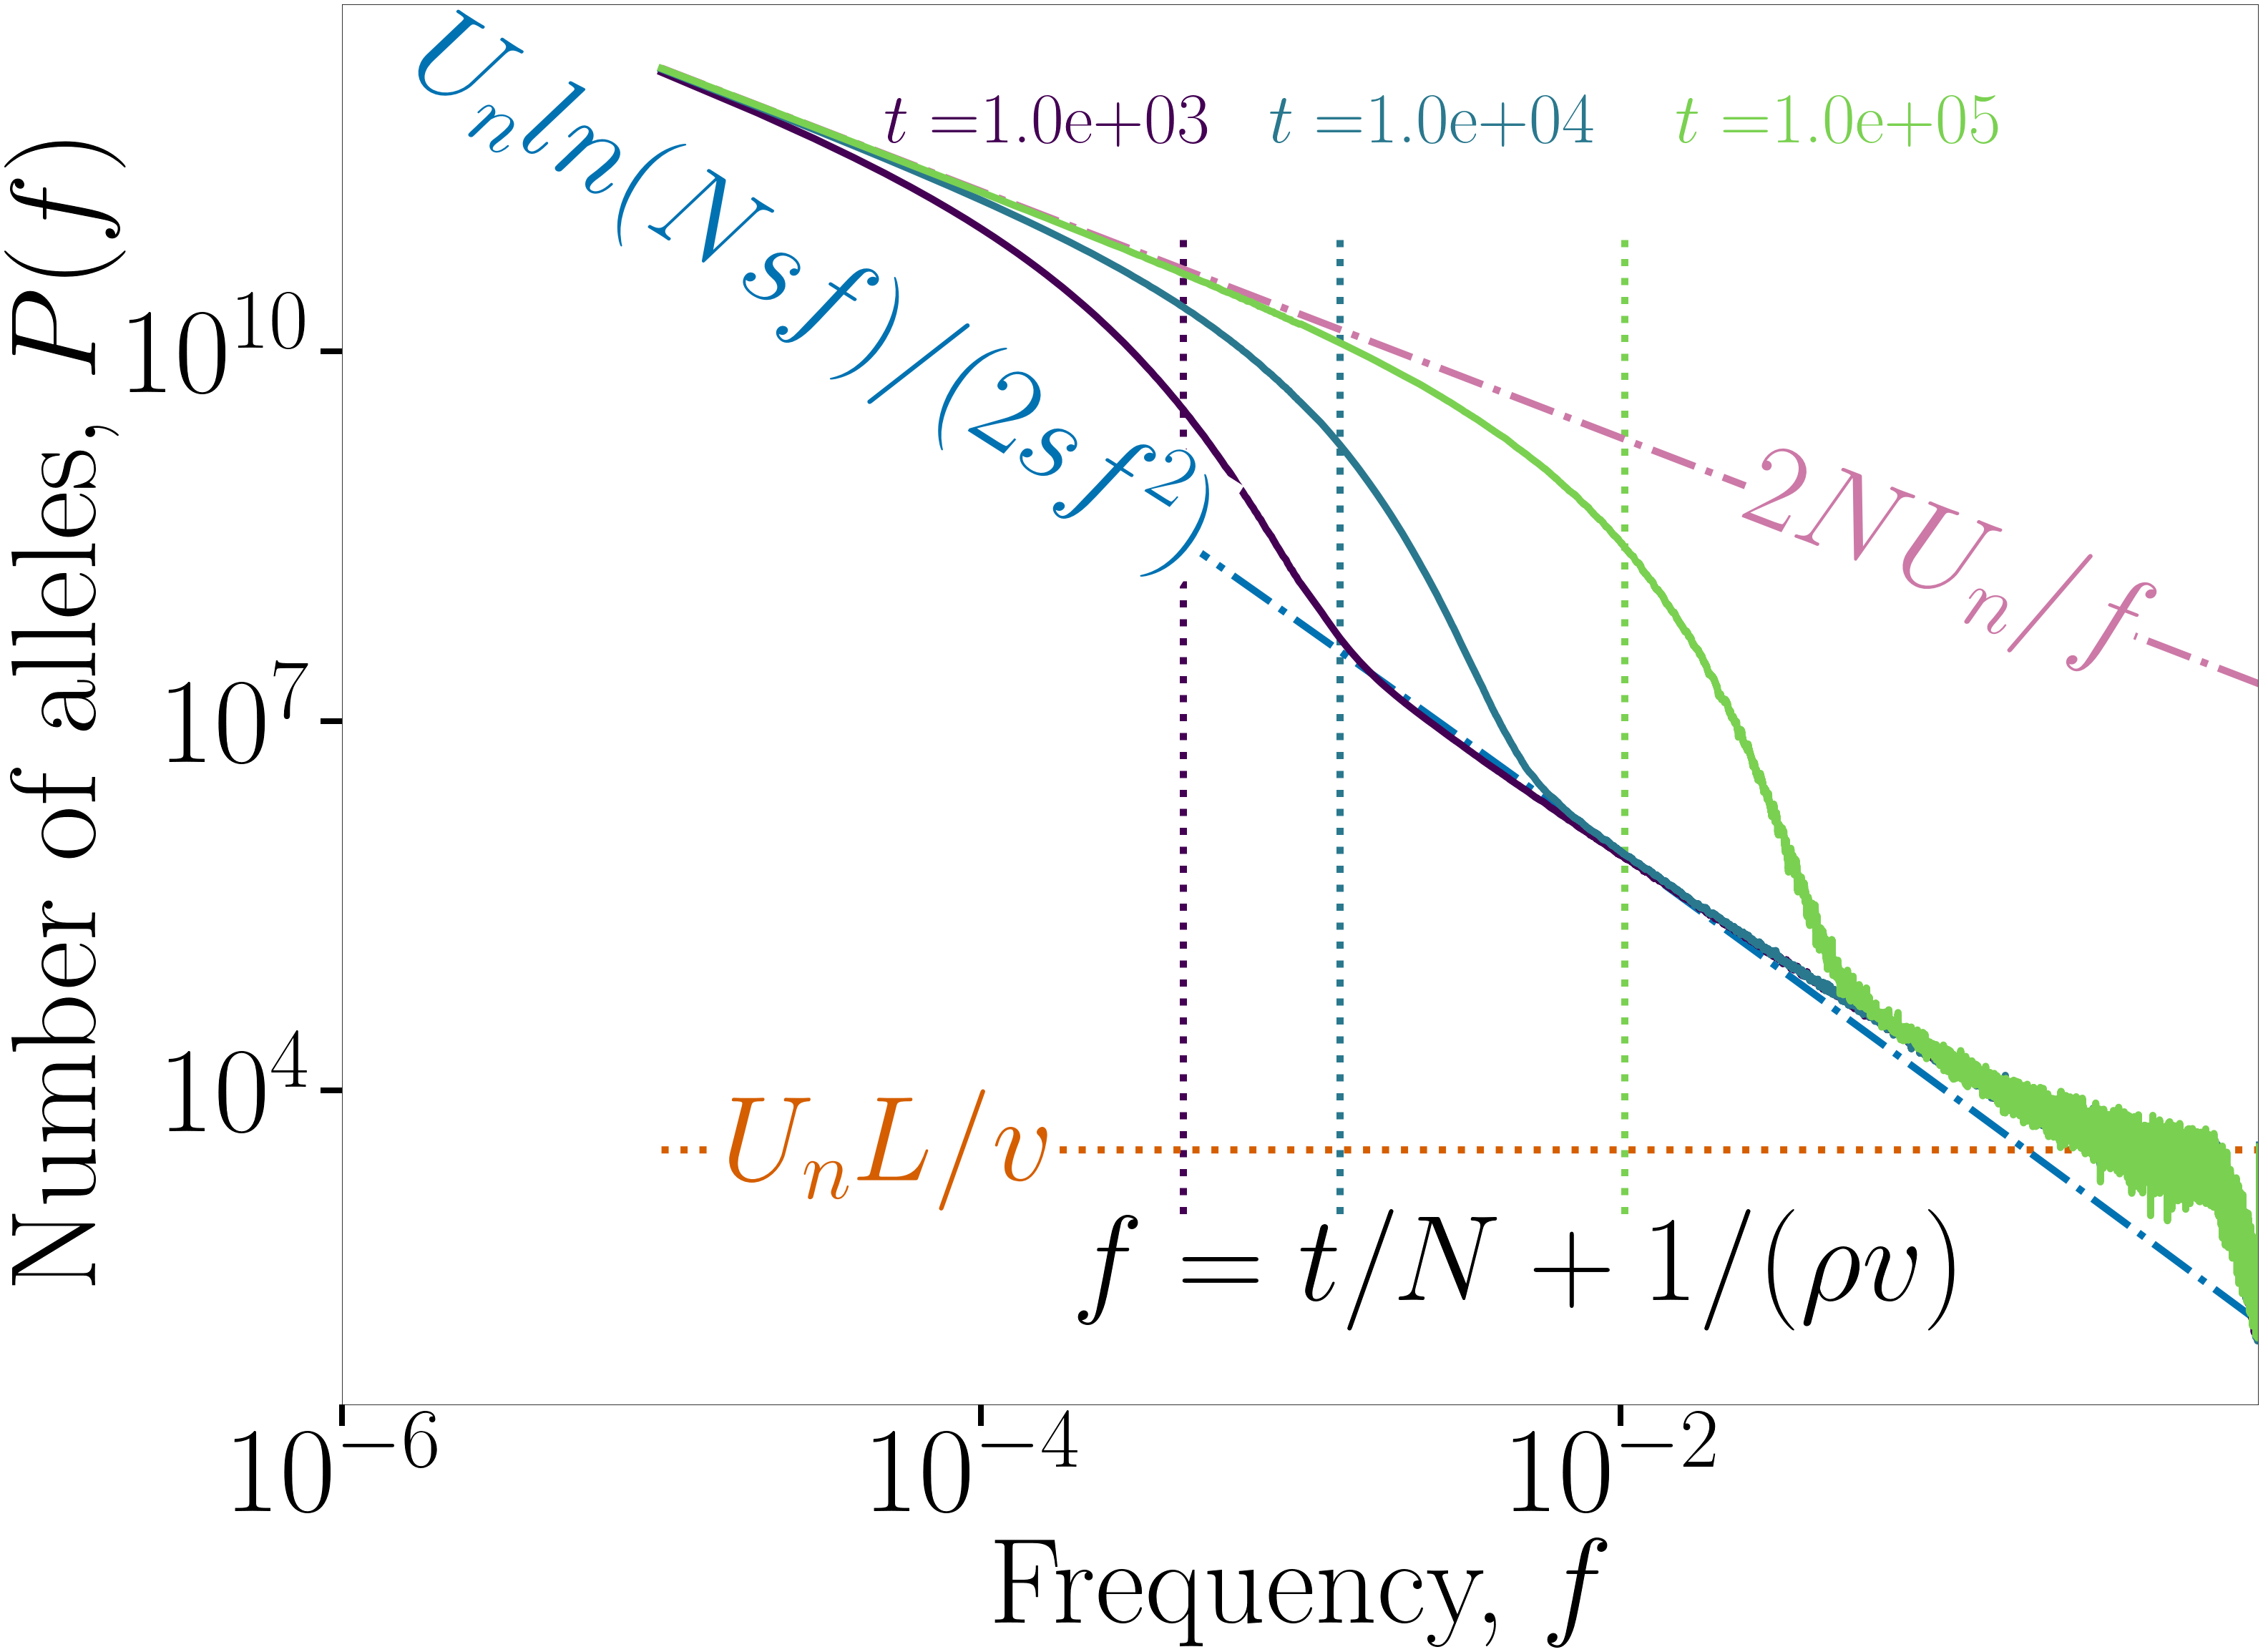

In [35]:
fig, ax = plt.subplots(figsize = (48, 36));
ax.set_xlabel(r'Frequency, $f$')
ax.set_ylabel(r'Number of alleles, $P(f)$')

L = 500
rho = 20000
N = L * rho
s = 0.05
m = 0.25
tfinal = 1000000
Un = 1
r = 0
n_forward = 100
tfix = 0


# Change m - sample everywhere
n = 100000
nSFS = 1000

tfixlist = [1000, 10000, 100000]
viridis_cmap = cm.get_cmap('viridis')

fitlist = []

f = np.arange(1, n + 1) / n
navg = 30
start_smooth = 100
f_short = moving_average(f, navg, start_smooth)

fit_range_ind = np.arange(200,1000)


freq_file = open(
   'forward_simulation_data/L={}_N={}_s={:.6f}_m={:.6f}_tfinal={}_0.txt'.format(
           L, rho, s, m, tfinal))
lines = np.loadtxt(freq_file, dtype=np.int64)
tf_real = len(lines)
v_list = []
for t in np.arange(int(tf_real / 4), int(tf_real * 3 / 4)):
    line1 = lines[t]
    line2 = lines[t + 1]
    psum1 = sum(line1) / rho
    psum2 = sum(line2) / rho
    v_list.append(psum2 - psum1)

v = np.average(v_list)
#xpositions = [6 * 10 ** (-5), 10 ** (-3), 10 ** (-2)]
xpositions = [5 * 10 ** (-5), 8 * 10 ** (-4), 1.5 * 10 ** (-2)]

ax.text(2 * 10 ** -4, 200, r'$\boldmath{f = t / N + 1 / (\rho v)}$')
flat, = ax.loglog(f_short, np.ones(len(f_short)) * L / v, linewidth = 10, 
           linestyle = 'dotted'
              , label = r'$ U_n L / v$', color = '#d55e00')
neutral, = ax.loglog(f_short, 
           2 * Un * N * np.ones(len(f_short)) / f_short,
           label = r'$2 N U_n / f$', linestyle = '-.',
           linewidth = 10, color = '#cc79a7')
bsc, = ax.loglog(f_short, 
           Un / (2 * s * f_short ** 2) * np.log(N * s * f_short), 
           label = r'$U_n ln(Nsf) / (2 s f^2)$', 
           linestyle = '-.', linewidth = 10, color = '#0072b2')

xvals = [5 * 10 ** (-5), 0.1, 3 * 10 ** -5]
labelLines(plt.gca().get_lines(), xvals = xvals, backgroundcolor = 'w')

for tind in range(len(tfixlist)):
    tfix = tfixlist[tind]
    # Find v from lines
    SFS = np.loadtxt(
        'backward_simulation_data/SFS_L={}_N={}_s={:.6f}_m={:.6f}_r={:.6f}_tfinal={}_nsample={}_tfix={}_sample_uniform_navg={}_avged.txt'.format(L, 
                 rho, s, m, r, tfinal, n, tfix, nSFS))

    ax.loglog(f_short, 
                 moving_average(SFS, navg, start_smooth), 
                 linewidth = 10, 
                 color = viridis_cmap(tind * 0.4), 
                 label = '$t =${:.2e}'.format(tfix))
    
    ax.vlines(tfix / N + 1 / (v * rho), 10 ** 3, 10 ** 11, linestyle = 'dotted',
               linewidth = 10, color = viridis_cmap(tind * 0.4))
    ax.text(xpositions[tind], 5 * 10 ** 11, 
             r'$\boldmath{t = }$' + '{:.1e}'.format(tfix), 
             color = viridis_cmap(tind * 0.4), fontsize = 100)    
    popt, pcov = curve_fit(power_law_fit, f[fit_range_ind], SFS[fit_range_ind])
    fitlist.append(popt[0])


ax.set_xlim((10 ** -6, 0.99))


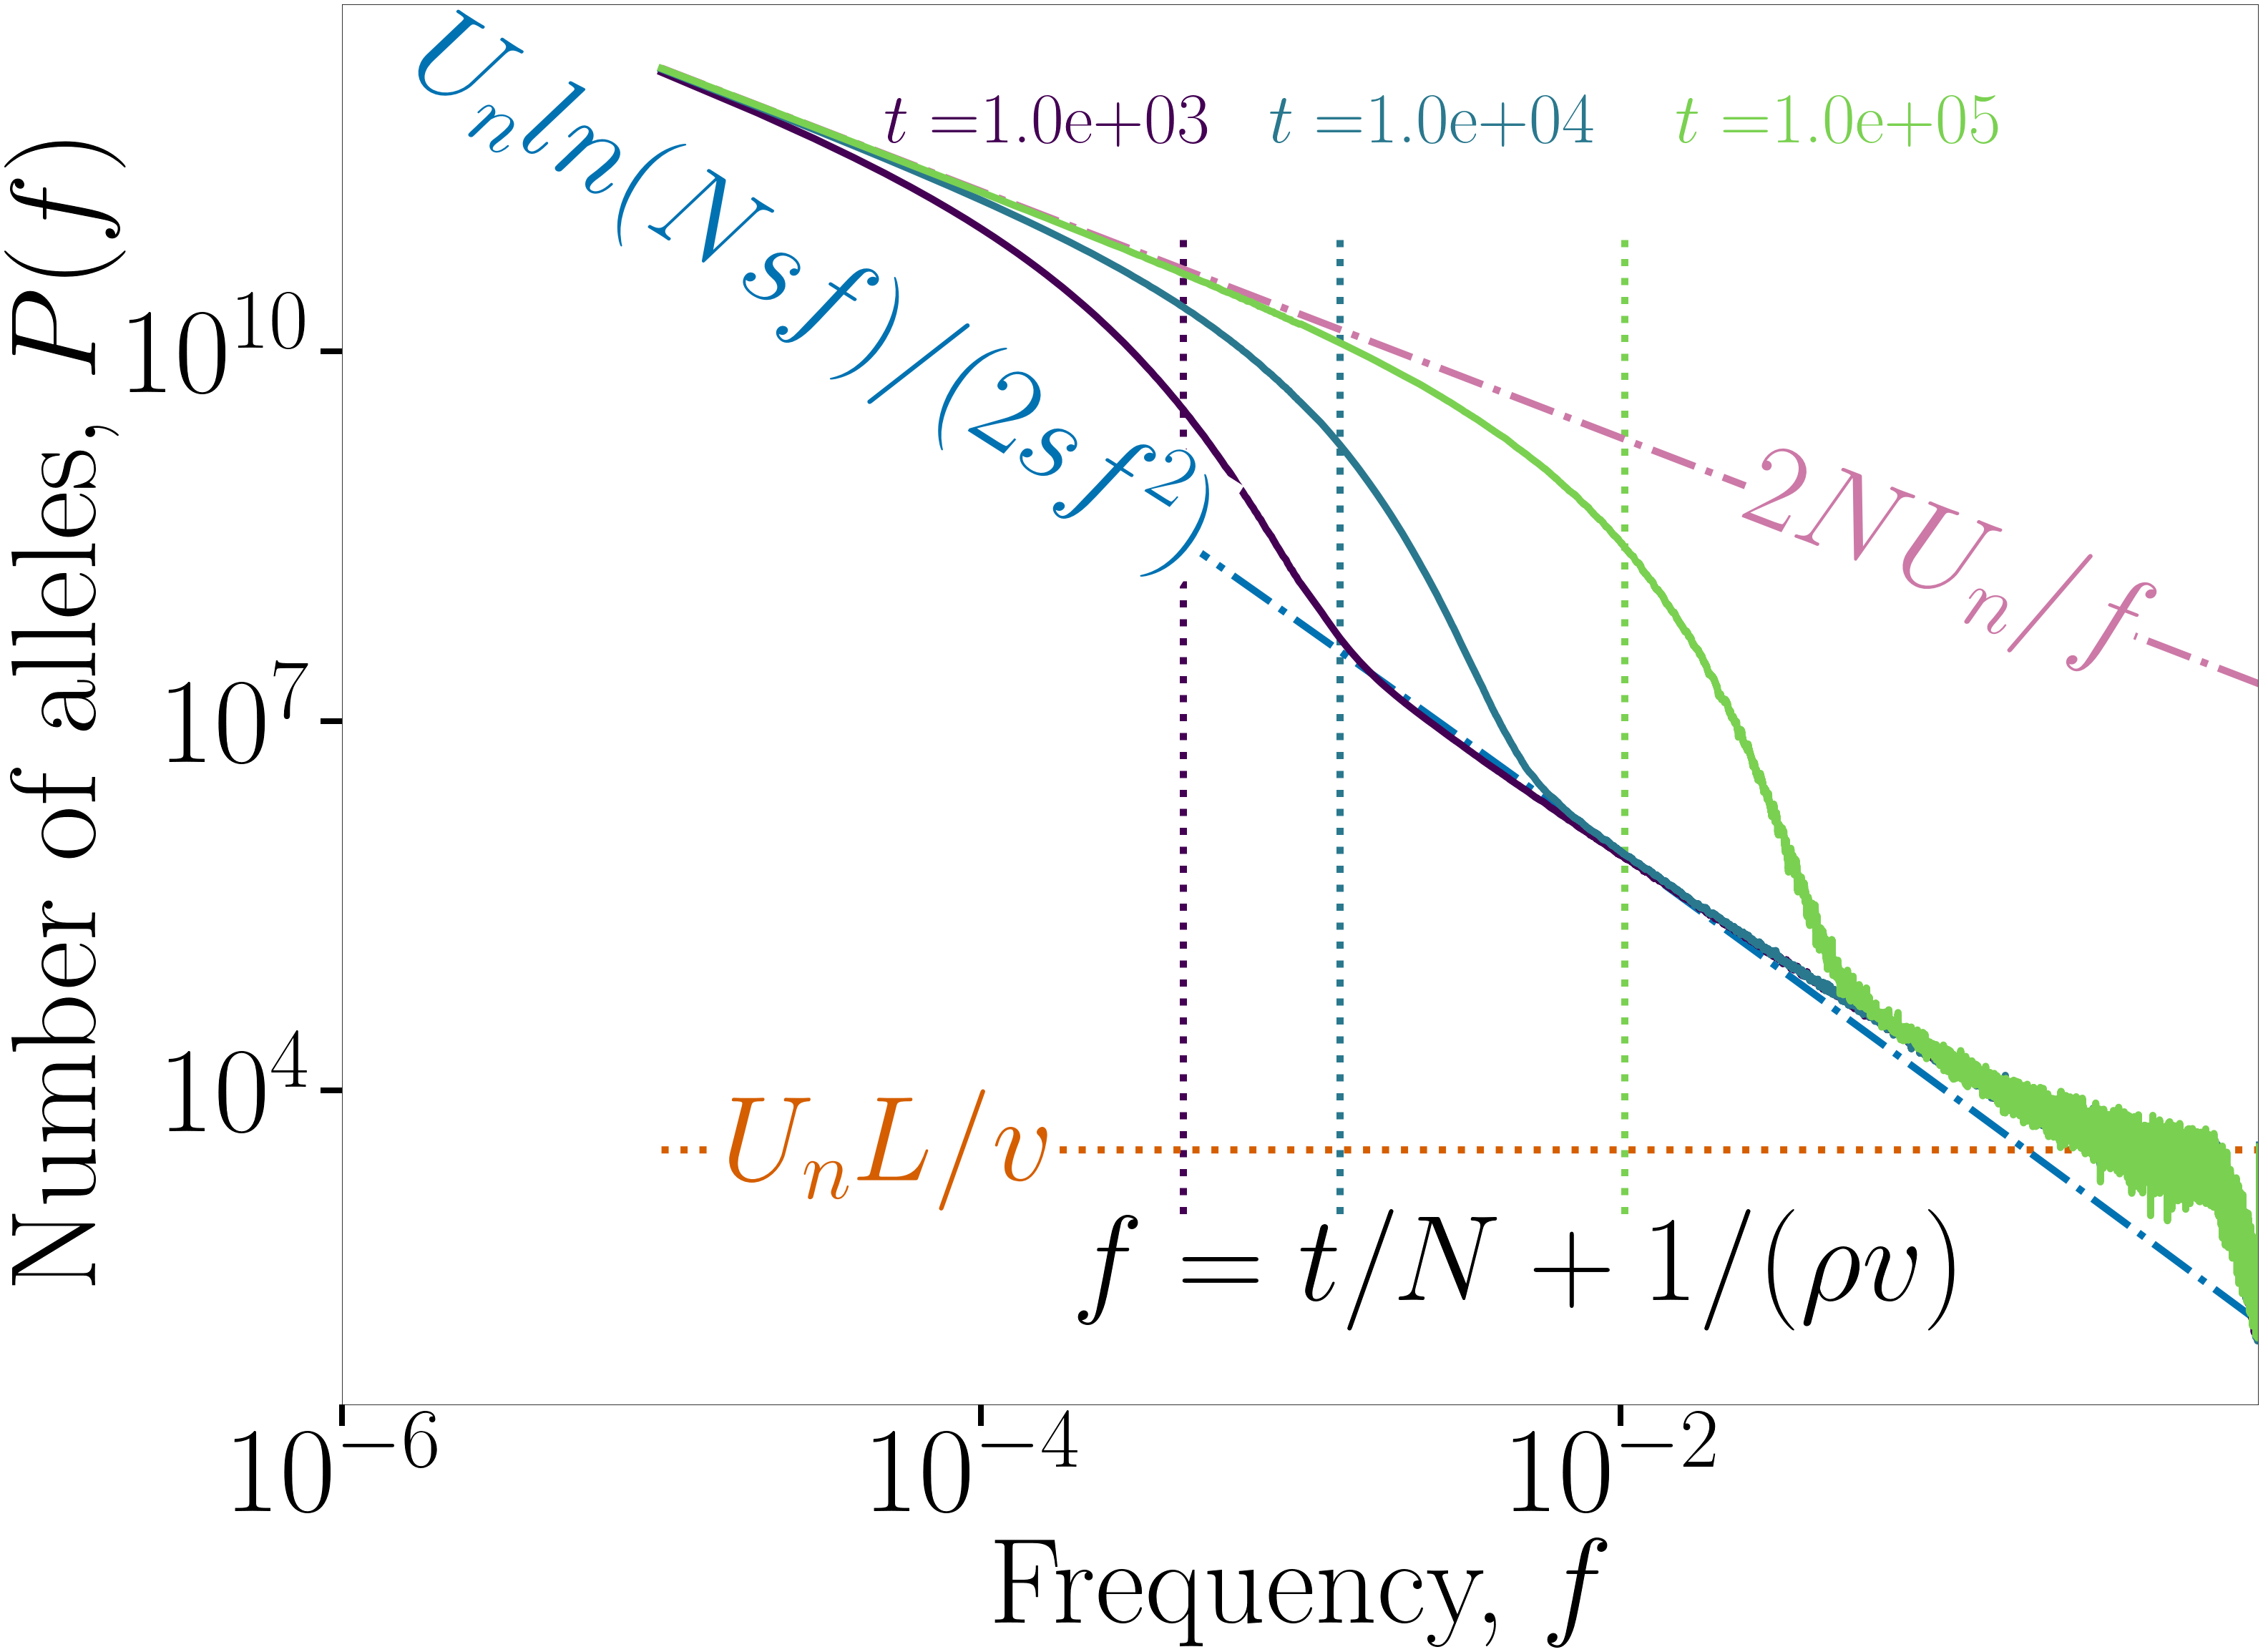

In [36]:
# save figure:
fig.savefig('Figure4.pdf', format = 'pdf', bbox_inches = 'tight')
fig